# Apprentissage non-supervisé

<img src="data/titanic.png">

Issu de la compétition Kaggle [Titanic](https://www.kaggle.com/c/titanic)

## Importation des librairies
On se base principalement sur les librairies `numpy` pour les manipulations de tableaux, `sklearn` pour les méthodes de machine learning et `matplotlib` pour la visualisation graphique.

In [1]:
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 40)
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Exercice n°1 : analyse en composantes principales
Dans cet exercice, on se propose d'identifier les composantes principales du jeu de données.

## Chargement du jeu de données
Pour commencer, nous chargeons le jeu de données en mémoire.

In [2]:
titanic = pd.read_csv('data/titanic.csv', sep='\t',index_col = "PassengerId")

## Pré-traitement du jeu de données

Afin de visualiser le jeu de données, on se restreint à un petit sous-ensemble de variables numériques.

### Question 1:

Choisir quelques variables numériques, puis les sélectionner. Nous ne nous baserons que sur ces variables pour la suite.

In [3]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Enfin, on extrait les données dans la variable `X` et la cible dans la variable `y`.

In [4]:
X = titanic[features]
y = titanic['Survived']

La plupart des techniques de visualisation nécessitent du preprocessing. Notamment, l'Analyse en Composantes Principales (ACP) nécessite des distributions centrées, relativement équilibrées, et sans valeurs manquantes.

### Question 2:

A l'aide d'objets de Sklearn, créer une pipeline sklearn d'objets permettant d'obtenir le traitement attendu. L'utilisation du LogTransformer (transformer qui à une variable $x$ associe $\ln(1+x)$ est vivement conseillé en début de pipeline.

On définit donc un pipeline de transformation `preprocess` :
* `LogTransfomer` qui à une variable $x$ associe $\ln(1+x)$. Cela permet de normaliser des distributions en loi de puissance.
* `RobustScaler` qui recentre une variable $x$ autour de sa médiane en ignorant les valeurs aberrantes.
* `SimpleImputer` qui remplace les valeurs manquantes d'une distribution par la médiane.

In [5]:
preprocess = make_pipeline(
    FunctionTransformer(np.log1p, validate=False),
    RobustScaler(),
    SimpleImputer(strategy='median')
)


Pour obtenir une version pré-traitée de `X`, on applique simplement la méthode `fit_transform`, qui renvoie un tableau `numpy`, et on enrobe le tout dans un `pandas` dataframe.

### Question 3:

Utiliser la pipeline pour transformer les données.

In [6]:
X_preprocessed = pd.DataFrame(
    preprocess.fit_transform(X),
    columns=X.columns,
    index=X.index
)

On peut par exemple comparer les distributions de la variable `Age` avant et après le pré-traitement.

### Question 4:

Réaliser cette comparaison et commenter.

Ici, on remarque plusieurs choses après traitement :
* les valeurs prises sont de l'ordre de quelques unités (`LogTransformer`)
* la distribution est centrée autour de zéro (`RobustScaler`)
* la distribution est piquée au milieu, ce sont les valeurs imputées (`SimpleImputer`)

C:\Users\Raphael\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Raphael\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


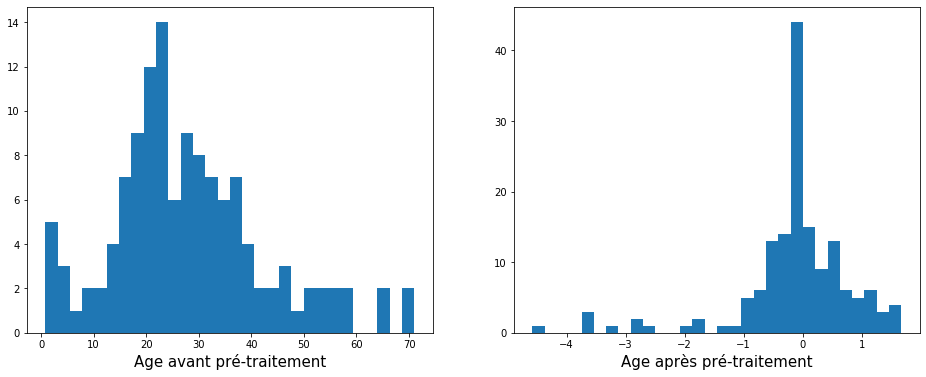

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist(X['Age'], bins=30)
ax[0].set_xlabel('Age avant pré-traitement', fontsize=15)
ax[1].hist(X_preprocessed['Age'], bins=30)
ax[1].set_xlabel('Age après pré-traitement', fontsize=15);

## Réduction de dimension
A présent, le jeu de données est prêt pour faire l'objet d'une analyse en composantes principales. On instancie donc un transformeur en ce sens. On ne garde que deux ou trois composantes pour la visualisation.

### Question 5:

Créer le Transformer et l'utiliser pour réduire la dimension des données. Vérifier et représenter le résultat.

In [8]:
pca = PCA(n_components=3)

On obtient une version compressée du jeux de données en appliquant la méthode `fit_transform` et en enrobant le tout dans un `pandas` dataframe.

In [9]:
X_pca = pd.DataFrame(
    pca.fit_transform(X_preprocessed), 
    columns=['comp1', 'comp2', 'comp3'], 
    index=X.index
)

La jeu de données obtenu contient autant de lignes que précédemment, mais avec seulement deux variables continues qui sont les composantes principales.

In [10]:
X_pca.shape

(156, 3)

In [11]:
X_pca.head()

comp1     comp2     comp3
PassengerId                              
1            0.790091 -0.421304 -0.418505
2           -1.826190  1.225561 -0.307469
3            0.373255 -0.953655  0.198845
4           -1.671396  1.172443 -0.206417
5            0.035774 -1.193699 -0.055744

On peut visualiser le jeu de données dans l'espace des composantes principales et inférer une certaine structure. 

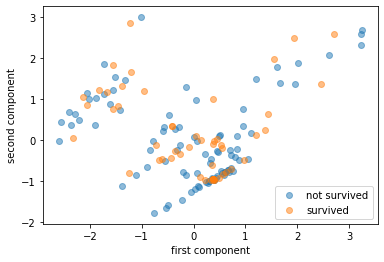

In [12]:
for target, label in zip([0,1], ['not survived', 'survived']):   
    df = X_pca[y == target]
    plt.scatter(df['comp1'], df['comp2'], label=label, alpha=0.5)
plt.xlabel('first component')
plt.ylabel('second component')
plt.legend(loc='best');

On peut légitimement se demander si les deux composantes principales retenues captent toute la variabilité des données.

### Question 6:

Comparer la variance expliquée des différentes composantes. Ensuite visualiser la combinaison linéaire résultant en chacune des nouvelles dimentions. Commenter.

La réponse se trouve dans le membre `explained_variance_ratio_` de notre PCA.

In [13]:
pca.explained_variance_ratio_

array([0.45216692, 0.36707623, 0.11851502])

Ici, on remarque la première composante principale explique à elle seule près de 45% de la variance totale, et que la seconde vient apporter 36% de variance supplémentaire ! La visualisation capte donc l'essentiel du signal présent dans les données.

On peut également se demander à quelles combinaisons linéaires correspondent les composantes principales. 

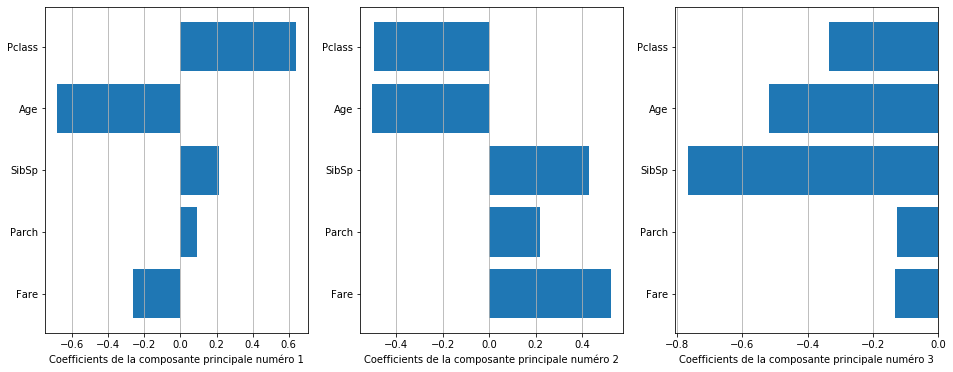

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
for i, ax in enumerate(axes):
    ax.barh(X_preprocessed.columns, pca.components_[i])
    ax.set_xlabel('Coefficients de la composante principale numéro {}'.format(i + 1))
    ax.xaxis.grid()
    ax.invert_yaxis()

**Attention !** L'analyse en composantes principales est non-supervisée (on n'a pas utilisé la cible `y`). On peut donc en conclure que les voyageurs se distinguent les uns des autres essentiellement par la classe, l'âge et la taille de leur famille, mais on ne peut rien en conclure quant à leurs chances de survie !

# Exercice n°2 : identifier des groupes similaires

Dans cet exercice, on se propose d'identifier des groupes similaires dans l'espace des composantes principales et d'identifier l'individu le plus représentatif de chaque groupe.

## Segmentation

On voit que se dessine clairement certains groupes de passagers. On peut essayer de les identifier avec un algorithme de clustering tel que `KMeans`.

### Question 7:

Mettre en place cette méthode de clustering (on créera 4 clusters) et visualiser les résultats.

In [15]:
n_clusters = 4
clustering = KMeans(n_clusters=n_clusters)
labels = clustering.fit_predict(X_pca[['comp1', 'comp2']])

On trace chaque point en codant l'appartenance à un cluster par la couleur.

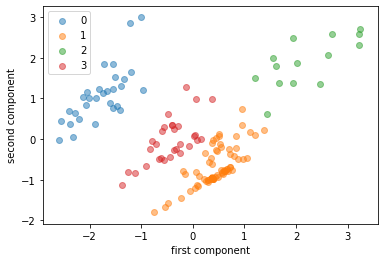

In [16]:
for label in range(n_clusters):
    df = X_pca[labels == label]
    plt.scatter(df['comp1'], df['comp2'], label=label, alpha=0.5)
plt.xlabel('first component')
plt.ylabel('second component')
plt.legend(loc='best');

On peut même représenter les trois dimensions de l'ACP via un graphique en trois dimensions.

No handles with labels found to put in legend.


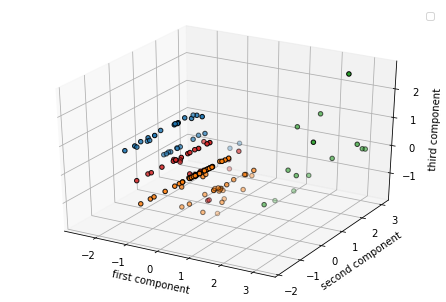

In [17]:
import mpl_toolkits.mplot3d.axes3d as p3
fig = plt.figure()
ax = p3.Axes3D(fig)
for label in range(n_clusters):
    ax.scatter(X_pca[labels == label].iloc[:,0], X_pca[labels == label].iloc[:, 1], X_pca[labels == label].iloc[:, 2],
               s=20, edgecolor='k')
ax.set_xlabel('first component')
ax.set_ylabel('second component')
ax.set_zlabel('third component')
plt.legend(loc='best');

Essayons maintenant de trouver l'individu le plus représentatif de chaque cluster. L'idée est de calculer le point le plus proche du centre de chaque cluster.

### Question 8:

Trouver les individus représentatifs de chacun des clusters.

In [18]:
closest, _ = pairwise_distances_argmin_min(clustering.cluster_centers_, X_pca[['comp1', 'comp2']])

On peut représenter les individus "les plus représentatifs" de chaque cluster (le résultat peut varier en fonction des paramètres utilisés).

In [19]:
for i in range(n_clusters):
   print("\nCluster {0}".format(i))
   print(titanic.iloc[closest[i]])


Cluster 0
Survived                              0
Pclass                                1
Name        Futrelle, Mr. Jacques Heath
Sex                                male
Age                                  37
SibSp                                 1
Parch                                 0
Ticket                           113803
Fare                               53.1
Cabin                              C123
Embarked                              S
Name: 138, dtype: object

Cluster 1
Survived                                          1
Pclass                                            3
Name        Johnson, Mrs. Oscar W (Elisabeth Vil...
Sex                                          female
Age                                              27
SibSp                                             0
Parch                                             2
Ticket                                       347742
Fare                                        11.1333
Cabin                                        

# Exercice n°3 : détection de points aberrants
Dans cet exercice, on se propose de détecter les points aberrants du jeu de données.

### Isolation Forest
Pour détecter (et visualiser) les points aberrants, on se base sur l'algorithme Isolation Forest ("forêts d'isolation") de scikit-learn.

**Principe des forêts d'isolation**     
Les forêts d'isolation sont basées sur l'idée qu'"une anomalie, c'est une observation séparée des autres", et donc que l'on peut isoler des autres observations en quelques subdivisions. L'algorithme va effectuer des subdivisions aléatoires successives du jeu de données, ce qui aboutit à un arbre de type "arbre de décision". Le processus est alors répété plusieurs fois, ce qui aboutit à une "forêt aléatoire". 
Le score d'anomalie d'une observation est une fonction décroissante du nombre moyen de subdivisions nécessaires pour l'isoler du reste du jeu de données. Plus le score est bas, plus l'observation est "anormale". Les observations avec un score en-dessous d'un certain seuil seront alors considérées comme des anomalies.
Le paramètre contamination permet de fixer la proportion du jeu de données considérée comme des anomalies et donc le seuil de score en-dessous duquel toute observation sera classifiée comme anomalie.

### Question 9:

Entraînez une forêt d'isolation, qui considère les 5% de points les plus anormaux comme des anomalies.

In [20]:
from sklearn.ensemble import IsolationForest
forest=IsolationForest(n_estimators=100,random_state=2020, contamination=0.05, behaviour="new")
forest.fit(X_preprocessed)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=2020, verbose=0, warm_start=False)

La prédiction se fait avec la ligne ci-après. Ici, on peut prédire sur le jeu  d'entraînement sans scrupules car il s'agit d'apprentissage non-supervisé (on n'utilise pas la cible `y`).

In [21]:
labels=forest.predict(X_preprocessed)
labels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

On peut aussi afficher directement les scores d'anomalies par la commande suivante : forest.score_samples(X_preprocessed), ce qui permet de tracer l'histogramme de ces scores d'anomalie.

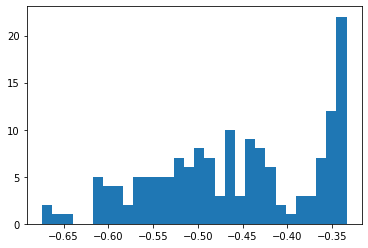

In [22]:
scores_ano=forest.score_samples(X_preprocessed)
plt.hist(scores_ano, bins=30);

### Visualisation des points aberrants

L'algorithme donne un score d'anomalie. On peut par exemple se servir de l'ACP réalisée précédemment comme support à la visualisation, la couleur indiquant le score d'anomalie.

**Attention** La détection d'anomalies et la réduction de dimension ne commutent pas ! Un point peut paraître normal sur la représentation 2D est quand même être une anomalie au global. Pour le comprendre, on peut prooser l'analogie est la suivante :
* Vous allez chez le coiffeur (détection d'anomalies)
* Vous vous regardez dans un miroir déformant (réduction de dimension)      
Vous n'obtiendrez pas le même résultat si vous êtes face à un miroir déformant pendant ou après la séance chez le coiffeur !      
      
Autre analogie possible : une photo de Pinocchio, *de face*, donne l'impression d'un visage normal...

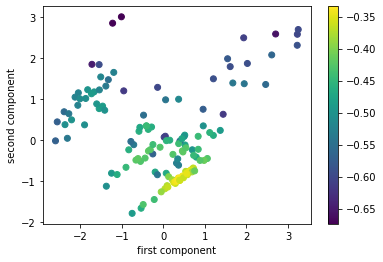

In [23]:
plt.scatter(X_pca['comp1'], X_pca['comp2'], c=scores_ano) #plus le score est faible, plus le point est aberrant
plt.colorbar()
plt.xlabel('first component')
plt.ylabel('second component');

### Exemples de points aberrants

Examinons de plus près les points aberrants trouvés par l'algorithme.

### Question 10:

Proposez un threshold (un seuil) et examinez les point aberrants. Est-ce le résultat attendu ?

Selon le seuil de détection que l'on se fixe, on trouve plus ou moins d'anomalies. Ici, on en retient une dizaine, et on remarque que ce sont principalement des personnes jeunes ! C'est donc l'âge qui semble être la première source d'anomalie. On remarque aussi que l'individu "anormal" de 19 ans a payé un prix élevé et faisait partie d'une famille nombreuse et riche (avec cabine en première classe).

In [24]:
ano_scores=-forest.score_samples(X_preprocessed)
threshold = -0.6
X[scores_ano<= threshold]

Pclass    Age  SibSp  Parch      Fare
PassengerId                                       
14                3  39.00      1      5   31.2750
17                3   2.00      4      1   29.1250
26                3  38.00      1      5   31.3875
28                1  19.00      3      2  263.0000
44                2   3.00      1      2   41.5792
69                3  17.00      4      2    7.9250
79                2   0.83      0      2   29.0000
89                1  23.00      3      2  263.0000
119               1  24.00      0      1  247.5208
137               1  19.00      0      2   26.2833

## Exercice n°4 : Etude du dataset Faces

Le dataset Faces contient 1000 miniatures d'images de visage. Il est très utilisé pour la visualisation.

In [25]:
data = scipy.io.loadmat('data/faces.mat')
X = data["X"]

### Question 11:

Créer un fonction permettant d'afficher certaines images du dataset, et l'utiliser pour afficher certaines images (Bonus si une photo de Johnny apparait).

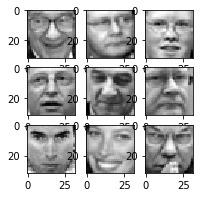

In [26]:
def plot_data(X, n_rows, n_cols):
    
    plt.figure(figsize=(n_cols, n_rows))

    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(X[i].reshape((32,32), order='F'), cmap=plt.cm.gray)
        
plot_data(X, 3,3)

### Question 12:

Mettre en place en méthode pour déterminer une topologie du dataset, des groupes d'individus etc...

On peut utiliser une PCA pour visualiser les visages types des personnes du dataset :

In [27]:
ss = StandardScaler()
pca = PCA(n_components=25)
pipeline =  make_pipeline(ss,pca)

In [28]:
X_trans = pipeline.fit_transform(X)

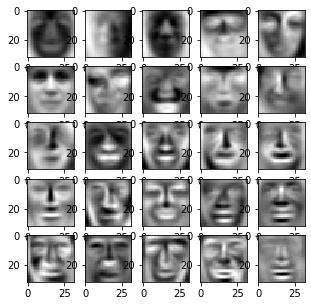

In [29]:
plot_data(pca.components_, 5, 5)

On voit que certains traits du visage ressortent bien dans les composantes de la PCA.

A partir de là, énormément d'approches sont envisageables.

## Bonus

Utiliser un auto-encoder pour trouver une représentation en faible dimension des images.

Le code ci-dessous est tiré de https://blog.keras.io/building-autoencoders-in-keras.html

In [30]:
import tensorflow.keras as keras
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(1024,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(1024, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


In [31]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [32]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [33]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [34]:
x_train = (128+X).astype("float32")[:4000,:] / 255.
x_test = (128+X).astype("float32")[4000:,:] / 255.
print(x_train.shape)
print(x_test.shape)

(4000, 1024)
(1000, 1024)


In [35]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 0s 108us/step - loss: 0.6937 - val_loss: 0.6931
Epoch 2/50
4000/4000 [==============================] - 0s 90us/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/50
4000/4000 [==============================] - 0s 93us/step - loss: 0.6928 - val_loss: 0.6927
Epoch 4/50
4000/4000 [==============================] - 0s 92us/step - loss: 0.6926 - val_loss: 0.6926
Epoch 5/50
4000/4000 [==============================] - 0s 118us/step - loss: 0.6925 - val_loss: 0.6924
Epoch 6/50
4000/4000 [==============================] - 0s 92us/step - loss: 0.6923 - val_loss: 0.6922
Epoch 7/50
4000/4000 [==============================] - 0s 95us/step - loss: 0.6920 - val_loss: 0.6919
Epoch 8/50
4000/4000 [==============================] - 0s 92us/step - loss: 0.6917 - val_loss: 0.6916
Epoch 9/50
4000/4000 [==============================] - 0s 89us/step - loss: 0.6914 - val_loss: 0.6912
Epoch 10/50
4000/4000 [

In [36]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs_2 = autoencoder.predict(x_test)

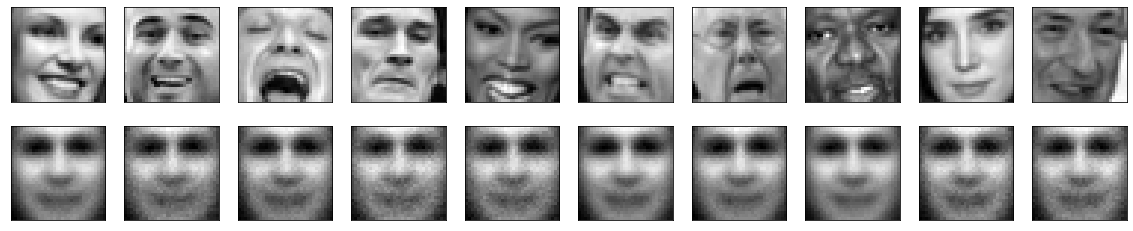

In [37]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, order="F"))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, order="F"))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()